In [1]:
import numpy as np
import pandas as pd
from  urlparse import urljoin 
import requests 
import bs4 as bs
from urllib2 import urlopen as req 
import sqlite3 as sql
import re
from datetime import datetime
from __future__ import unicode_literals

In [2]:
conn = sql.connect('data.db')
c = conn.cursor()

c.execute("CREATE TABLE IF NOT EXISTS URLs (url text)")

c.execute("CREATE TABLE IF NOT EXISTS reviews (name text, review text)")

In [4]:
end_point = "https://www.yelp.com/search?"
search_term = "Restaurants"
city = "Hamilton"
province = "ON"
country = "Canada"
sorting = "rating"
businesses = []

#print(datetime.now())

for page_number in range(0,191, 10):

    listing_url = (end_point + "find_desc=" + search_term + "&find_loc=" + city + ",+" + province + ",+" + country
    + "&start=" + str(page_number)  )
    
    source = req(listing_url)
    soup = bs.BeautifulSoup(source ,'lxml') 
    businesses += soup.find_all('a', {'class': 'biz-name'})
    
links = [link['href'] for link in businesses]

links[:10]

#print(datetime.now())
    
    

['/adredir?ad_business_id=-LfQYorJljSwYFitXDsk0A&campaign_id=NpoGsz9JXMK4tlZCIeo4Iw&click_origin=search_results&placement=above_search&redirect_url=https%3A%2F%2Fwww.yelp.com%2Fbiz%2Fselect-sandwich-burlington&request_id=7bae5c9e3826cb4c&signature=c02803d47dea77d0c76272fca85eecec28bf71eacc38224d8b5512ec476bf092&slot=0',
 '/biz/rapscallion-rogue-eatery-hamilton?osq=Restaurants',
 '/biz/earth-to-table-bread-bar-hamilton?osq=Restaurants',
 '/biz/charred-chicken-hamilton?osq=Restaurants',
 '/biz/the-ship-hamilton?osq=Restaurants',
 '/biz/aberdeen-tavern-hamilton-2?osq=Restaurants',
 '/biz/mezcal-tacos-and-tequila-hamilton?osq=Restaurants',
 '/biz/541-eatery-and-exchange-hamilton?osq=Restaurants',
 '/biz/fsh-and-chp-hamilton?osq=Restaurants',
 '/biz/pokeh-hamilton?osq=Restaurants']

In [5]:
regex = re.compile("^/adredir")
business_links = [i for i in links if not regex.search(i)]


In [6]:
business_links[0].split('?')[0].split('/')[-1].replace("-", " ").replace("hamilton", " ")

u'rapscallion rogue eatery  '

In [9]:
c.execute("INSERT INTO URLs (url) VALUES ('{}')".format("'), ('".join(business_links)))
conn.commit()

In [30]:
res = conn.execute("SELECT * FROM URLs")
restaurants = [_[0] for _ in res.fetchall()]
len(restaurants)

200

In [11]:
review_divs = []
for restaurant in restaurants:

    source = req('https://www.yelp.com/' + restaurant)
    soup = bs.BeautifulSoup(source ,'lxml') 
    review_divs = soup.find_all('div', {'class': 'review-content'})
    name = soup.find_all('h1', {'class': 'biz-page-title'})[0].text.strip()
    reviews = [review.find_all('p')[0].text for review in review_divs]
    
#     print('INSERT INTO reviews (name, review) VALUES {}, "{}")'.format(
#         '("' + name + '"' ,
#         (( '"),("' + name + '","').join(
#             reviews))))

    c.executemany('INSERT INTO reviews (name, review) VALUES (?,?)', zip([name]*len(reviews), reviews))
    conn.commit()


In [12]:
conn = sql.connect('data.db')
c = conn.cursor()
result = conn.execute("SELECT * FROM reviews")

rev = pd.DataFrame([_ for _ in result.fetchall()])
rev.columns=['restaurant', 'review']
rev.head()

,restaurant,review
0,Rapscallion Rogue Eatery,"Honestly, I had driven by this place about a m..."
1,Rapscallion Rogue Eatery,I found this gem through Yelp while my bf and ...
2,Rapscallion Rogue Eatery,Absolutly an amazing meal we had! Service was ...
3,Rapscallion Rogue Eatery,This place was great. It doesn't look like muc...
4,Rapscallion Rogue Eatery,Amazing staff who are generally pretty helpful...


TF-IDF = Term Frequency times Inverse Document Frequency

TF: the number of times the word appears in the current document
DF: the numer of documents the word appears in
IDF: 1/DF

Your plot: first 2 terms against eachother. 
Per term DF is fixed: DF1, DF2 are (independent) numbers

A sample has 



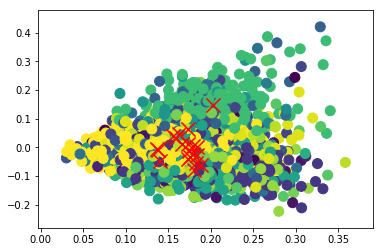

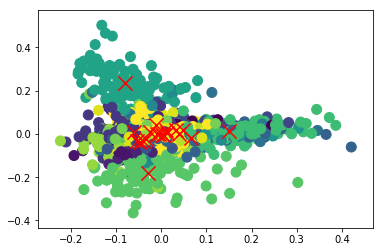

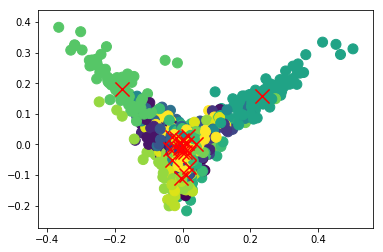

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(stop_words='english',max_df=.9)
vectorized = vectorizer.fit_transform(rev['review'].values)

reducer = TruncatedSVD(n_components=100, algorithm="randomized", n_iter=5, random_state=None, tol=0.0)

reduced_vector = reducer.fit_transform(vectorized)


true_k = 20
model = KMeans(n_clusters=true_k, init='random', max_iter=100, n_init=30)
predicted_labels = model.fit_predict(reduced_vector)

centroids = model.cluster_centers_

%matplotlib inline
import matplotlib.pyplot as plt


plt.scatter(reduced_vector[:,0], reduced_vector[:,1], s=100, c=predicted_labels)
plt.scatter(centroids[:,0], centroids[:,1], marker="x", c='red', s=200)
plt.show()
plt.scatter(reduced_vector[:,1], reduced_vector[:,2], s=100, c=predicted_labels)
plt.scatter(centroids[:,1], centroids[:,2], marker="x", c='red', s=200)
plt.show()
plt.scatter(reduced_vector[:,2], reduced_vector[:,3], s=100, c=predicted_labels)
plt.scatter(centroids[:,2], centroids[:,3], marker="x", c='red', s=200)

In [144]:
expanded=reducer.inverse_transform(centroids)
relevant = (expanded > 0.04).astype(int)
u=vectorizer.inverse_transform(relevant)


In [138]:
rev.head()

,restaurant,review,cluster
0,Rapscallion Rogue Eatery,"Honestly, I had driven by this place about a m...",1
1,Rapscallion Rogue Eatery,I found this gem through Yelp while my bf and ...,1
2,Rapscallion Rogue Eatery,Absolutly an amazing meal we had! Service was ...,1
3,Rapscallion Rogue Eatery,This place was great. It doesn't look like muc...,1
4,Rapscallion Rogue Eatery,Amazing staff who are generally pretty helpful...,1


In [143]:
#"".join(rev.loc[rev.cluster == 1,'review'])

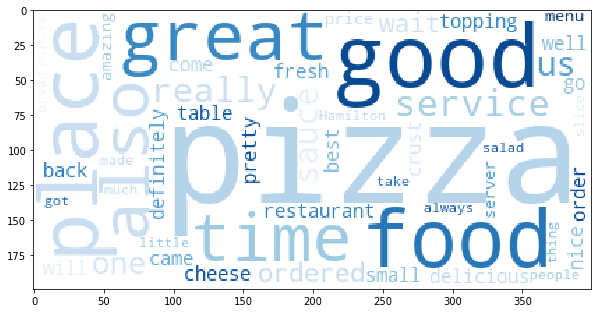

In [179]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(    background_color='white',
                          stopwords=set(STOPWORDS),
                          max_words=50,
                          max_font_size=100,
                          colormap = 'Blues'
                         ).generate("".join(rev.loc[rev.cluster == 3,'review']))

print(wordcloud)
fig = plt.figure(1, figsize=(10,8))
plt.imshow(wordcloud)

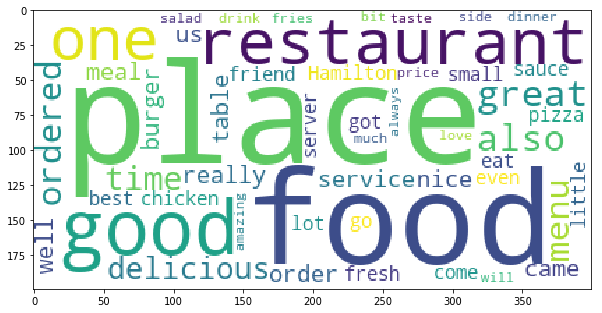

In [175]:
wordcloud = WordCloud(    background_color='white',
                          stopwords=set(STOPWORDS),
                          max_words=50,
                          max_font_size=100, 
                         ).generate("".join(rev['review'].values))

print(wordcloud)
fig = plt.figure(1, figsize= (10,8))
plt.imshow(wordcloud)